In [ ]:
# Import the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

In [ ]:
# Initial block of ENet architecture that performs efficient downsampling and feature expansion

class InitialBlock(nn.Module):

    # init block
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        # Choosing activation function based on relu parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - performs a 3x3 convolution with stride 2
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch - performs max pooling with stride 2
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initializing batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function to be applied after concatenating the branches
        self.out_activation = activation()

    # Forward block
    def forward(self, x):
        # Processing input through the main branch
        main = self.main_branch(x)

        # Processing input through the extension branch
        ext = self.ext_branch(x)

        # Concatenating main and extension branches along the channel dimension
        out = torch.cat((main, ext), 1)

        # Applying batch normalization to the concatenated output
        out = self.batch_norm(out)

        # Applying activation function to the normalized output
        return self.out_activation(out)


In [ ]:
# Bottleneck module for ENet architecture

class RegularBottleneck(nn.Module):

    # init block
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Ensuring internal_ratio is within valid range
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_ratio={1}."
                               .format(channels, internal_ratio))

        # Calculate the number of internal channels for the extension branch
        internal_channels = channels // internal_ratio

        # Choosing activation function based on relu parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Determine if asymmetric convolutions are used
        if asymmetric:
            # Asymmetric convolution: split the main convolution into two steps
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            # Regular or dilated convolution
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        # Dropout regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # Activation function to be applied after adding the branches
        self.out_activation = activation()

    # Forward block
    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch processing
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        # Applying activation function to the combined output
        return self.out_activation(out)


In [ ]:
# Downsampling bottleneck module for ENet architecture
class DownsamplingBottleneck(nn.Module):

    # init block
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameter for whether to return max pooling indices
        self.return_indices = return_indices

        # Ensure internal_ratio is within valid range
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_ratio={1}. "
                               .format(in_channels, internal_ratio))

        # Calculate the number of internal channels for the extension branch
        internal_channels = in_channels // internal_ratio

        # Choosing activation function based on relu parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling layer with stride 2
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - consists of three convolutional layers
        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 3x3 convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        # Dropout regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # Activation function to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch processing with optional return of max pooling indices
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch processing
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Check if main is on CPU or GPU and convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate main branch with padding and extension branch
        main = torch.cat((main, padding), 1)

        # Adding main and extension branches
        out = main + ext

        # Applying activation function to the combined output
        return self.out_activation(out), max_indices


In [ ]:
# Upsampling bottleneck module for ENet architecture
class UpsamplingBottleneck(nn.Module):

    # init block
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Ensure internal_ratio is within valid range
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_ratio={1}. "
                               .format(in_channels, internal_ratio))

        # Calculate the number of internal channels for the extension branch
        internal_channels = in_channels // internal_ratio

        # Choosing activation function based on relu parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - 1x1 convolution followed by max unpooling
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Max unpooling layer to reverse the effect of max pooling
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - consists of three convolutional layers
        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution (upsampling)
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Dropout regularization
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # Activation function to apply after adding the branches
        self.out_activation = activation()

    # Forward block
    def forward(self, x, max_indices, output_size):
        # Main branch processing with max unpooling
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch processing
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        # Applying activation function to the combined output
        return self.out_activation(out)


In [ ]:
# ENet model for real-time semantic segmentation
class ENet(nn.Module):

    # init block
    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        # Initial block
        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    # Forward block
    def forward(self, x):
        # Save initial input size for final transposed convolution
        input_size = x.size()

        # Initial block processing
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x


In [ ]:
# Instantiate the ENet model with 12 classes for segmentation
enet = ENet(12)

In [ ]:
# Check if a CUDA-enabled GPU is available and set the device accordingly
# If a GPU is available, use 'cuda:0', otherwise use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Print the device being used
print(device)

# Move the ENet model to the specified device (GPU or CPU)
enet = enet.to(device)


cuda:0


In [ ]:
# Load the dataset
def loader(training_path, segmented_path, batch_size, h=320, w=1000):
    # Get list of filenames in the training and segmented directories
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)

    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)

    # Ensure the number of training and segmented images are the same
    assert(total_files_t == total_files_s)

    # If batch size is set to 'all', use the total number of files
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s

    idx = 0
    while(1):
        # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)

        inputs = []
        labels = []

        for jj in batch_idxs:
            # Reading normalized training image
            img = plt.imread(training_path + filenames_t[jj])
            # Resizing image using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)

            # Reading segmented image
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
            # Resizing image using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(img)

        # Stack inputs along a new dimension and convert to tensor
        inputs = np.stack(inputs, axis=2)
        # Change image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)

        # Convert labels to tensor
        labels = torch.tensor(labels)

        # Yield the batch of inputs and labels
        yield inputs, labels


In [ ]:
def get_class_weights(num_classes, c=1.02):
    # Load all training images and their corresponding labels using the loader function
    pipe = loader('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/train/',
                  '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/trainannot/',
                  batch_size='all')

    # Get the labels from the loader
    _, labels = next(pipe)

    # Flatten the labels to a 1D array
    all_labels = labels.flatten()

    # Count occurrences of each class in the labels
    each_class = np.bincount(all_labels, minlength=num_classes)

    # Calculate propensity score for each class
    prospensity_score = each_class / len(all_labels)

    # Calculate class weights using the log function to handle class imbalance
    class_weights = 1 / (np.log(c + prospensity_score))

    return class_weights


In [ ]:
# Calculate class weights for 12 classes
class_weights = get_class_weights(12)


/tmp/ipykernel_4167/4210974233.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  labels = torch.tensor(labels)


In [ ]:
# Learning rate for the optimizer
lr = 5e-4

# Batch size for training
batch_size = 5

# Loss function: CrossEntropyLoss with class weights to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

# Optimizer: Adam optimizer with specified learning rate and weight decay
optimizer = torch.optim.Adam(enet.parameters(),
                             lr=lr,
                             weight_decay=2e-4)

# Frequency of printing training progress
print_every = 5

# Frequency of evaluating the model on the validation set
eval_every = 5


In [ ]:
# Lists to store training and evaluation losses
train_losses = []
eval_losses = []

# Number of mini-batches for training and validation
bc_train = 367 // batch_size
bc_eval = 101 // batch_size

# Define data loaders for training and validation datasets
pipe = loader('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/train/',
              '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/trainannot/',
              batch_size)
eval_pipe = loader('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/val/',
                   '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/valannot/',
                   batch_size)

# Number of epochs to train
epochs = 100

# Training loop
for e in range(1, epochs + 1):

    train_loss = 0
    print('-' * 15, 'Epoch %d' % e, '-' * 15)

    # Set the model to training mode
    enet.train()

    # Training mini-batches
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)

        # Move data to the specified device (GPU or CPU)
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass
        out = enet(X_batch.float())

        # Loss calculation
        loss = criterion(out, mask_batch.long())

        # Backward pass to update weights
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

    # Print an empty line for better formatting
    print()
    # Append training loss for the current epoch
    train_losses.append(train_loss)

    # Print training loss every 'print_every' epochs
    if (e + 1) % print_every == 0:
        print('Epoch {}/{}...'.format(e, epochs),
              'Loss {:6f}'.format(train_loss))

    # Evaluate the model every 'eval_every' epochs
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()

            eval_loss = 0

            # Validation mini-batches
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                # Move data to the specified device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                out = enet(inputs)

                # Get the predicted class with the highest score
                out = out.data.max(1)[1]

                # Accumulate evaluation loss
                eval_loss += (labels.long() - out.long()).sum()

            # Print evaluation loss for the current epoch
            print()
            print('Loss {:6f}'.format(eval_loss))

            # Append evaluation loss for the current epoch
            eval_losses.append(eval_loss)

    # Save model checkpoint every 'print_every' epochs
    if e % print_every == 0:
        checkpoint = {
            'epochs': e,
            'state_dict': enet.state_dict()
        }
        torch.save(checkpoint, '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print('Model saved!')

# Print total mean loss at the end of training
print('Epoch {}/{}...'.format(e, epochs),
      'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))


--------------- Epoch 1 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 2 ---------------


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.82it/s]



--------------- Epoch 3 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 4 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



Epoch 4/100... Loss 107.524306
--------------- Epoch 5 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.51it/s]



Loss 9560797.000000
Model saved!
--------------- Epoch 6 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 7 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 8 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 9 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



Epoch 9/100... Loss 90.625184
--------------- Epoch 10 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]



Loss -6852225.000000
Model saved!
--------------- Epoch 11 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 12 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 13 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.76it/s]



--------------- Epoch 14 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Epoch 14/100... Loss 82.344862
--------------- Epoch 15 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]



Loss -21295676.000000
Model saved!
--------------- Epoch 16 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 17 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 18 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 19 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Epoch 19/100... Loss 74.039078
--------------- Epoch 20 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.85it/s]



Loss -28116655.000000
Model saved!
--------------- Epoch 21 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 22 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 23 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 24 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]



Epoch 24/100... Loss 67.545581
--------------- Epoch 25 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.88it/s]



Loss -8914240.000000
Model saved!
--------------- Epoch 26 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 27 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 28 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 29 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



Epoch 29/100... Loss 63.755902
--------------- Epoch 30 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.92it/s]



Loss -19883669.000000
Model saved!
--------------- Epoch 31 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 32 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 33 ---------------


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.81it/s]



--------------- Epoch 34 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]



Epoch 34/100... Loss 59.995289
--------------- Epoch 35 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]



Loss -13134461.000000
Model saved!
--------------- Epoch 36 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 37 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 38 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 39 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



Epoch 39/100... Loss 55.330839
--------------- Epoch 40 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.99it/s]



Loss -13473820.000000
Model saved!
--------------- Epoch 41 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 42 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 43 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 44 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Epoch 44/100... Loss 51.758105
--------------- Epoch 45 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.99it/s]



Loss -14230206.000000
Model saved!
--------------- Epoch 46 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 47 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.76it/s]



--------------- Epoch 48 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 49 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]



Epoch 49/100... Loss 48.972821
--------------- Epoch 50 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]



Loss -7667130.000000
Model saved!
--------------- Epoch 51 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 52 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 53 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 54 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



Epoch 54/100... Loss 48.936235
--------------- Epoch 55 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]



Loss -13509704.000000
Model saved!
--------------- Epoch 56 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 57 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 58 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.76it/s]



--------------- Epoch 59 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Epoch 59/100... Loss 47.087692
--------------- Epoch 60 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.87it/s]



Loss -12979712.000000
Model saved!
--------------- Epoch 61 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 62 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 63 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 64 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



Epoch 64/100... Loss 44.758387
--------------- Epoch 65 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.96it/s]



Loss -11383325.000000
Model saved!
--------------- Epoch 66 ---------------


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.81it/s]



--------------- Epoch 67 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 68 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 69 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



Epoch 69/100... Loss 42.693553
--------------- Epoch 70 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.02it/s]



Loss -11537519.000000
Model saved!
--------------- Epoch 71 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 72 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 73 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 74 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



Epoch 74/100... Loss 42.710724
--------------- Epoch 75 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]



Loss -11575881.000000
Model saved!
--------------- Epoch 76 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 77 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 78 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 79 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



Epoch 79/100... Loss 41.855834
--------------- Epoch 80 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  5.00it/s]



Loss -17303746.000000
Model saved!
--------------- Epoch 81 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 82 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 83 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 84 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



Epoch 84/100... Loss 41.061830
--------------- Epoch 85 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.93it/s]



Loss -14848331.000000
Model saved!
--------------- Epoch 86 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 87 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]



--------------- Epoch 88 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 89 ---------------


100%|███████████████████████████████████████████| 73/73 [00:25<00:00,  2.81it/s]



Epoch 89/100... Loss 39.526032
--------------- Epoch 90 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.00it/s]



Loss -13607915.000000
Model saved!
--------------- Epoch 91 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



--------------- Epoch 92 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 93 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 94 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



Epoch 94/100... Loss 40.045227
--------------- Epoch 95 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.77it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.94it/s]



Loss -15284123.000000
Model saved!
--------------- Epoch 96 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 97 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.80it/s]



--------------- Epoch 98 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.79it/s]



--------------- Epoch 99 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.78it/s]



Epoch 99/100... Loss 38.312446
--------------- Epoch 100 ---------------


100%|███████████████████████████████████████████| 73/73 [00:26<00:00,  2.81it/s]


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]



Loss -12683727.000000
Model saved!
Epoch 100/100... Total Mean Loss: 57.321902


In [ ]:
# Save the parameters
checkpoint = {
    'epochs' : e,
    'state_dict' : enet.state_dict()
}
torch.save(checkpoint, '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/ckpt-enet.pth')

In [ ]:
# Save the model
torch.save(enet, '/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/model.pt')

In [ ]:
# # Load a pretrained model if needed
enet = ENet(12)
state_dict = torch.load('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/ckpt-enet.pth')['state_dict']
enet.load_state_dict(state_dict)
enet = enet.to(device)

In [ ]:
# Filename of the test image
fname = 'Seq05VD_f05070.png'

# Read the test image using matplotlib
tmg_ = plt.imread('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/test/' + fname)

# Resize the image to 512x512 using nearest neighbor interpolation
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_NEAREST)

# Convert the image to a torch tensor and add a batch dimension
tmg = torch.tensor(tmg_).unsqueeze(0).float()

# Change the image format to match the expected input shape (C x H x W)
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

# Move the ENet model to the specified device (GPU or CPU)
enet.to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    # Forward pass through the model to get predictions
    out1 = enet(tmg.float()).squeeze(0)


In [ ]:
# Open the corresponding ground truth segmentation image using PIL
smg_ = Image.open('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/testannot/' + fname)

# Convert the PIL image to a numpy array and resize it to 512x512 using nearest neighbor interpolation
smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)


In [ ]:
# Move the output tensor to the CPU and detach it from the computational graph
out2 = out1.cpu().detach().numpy()

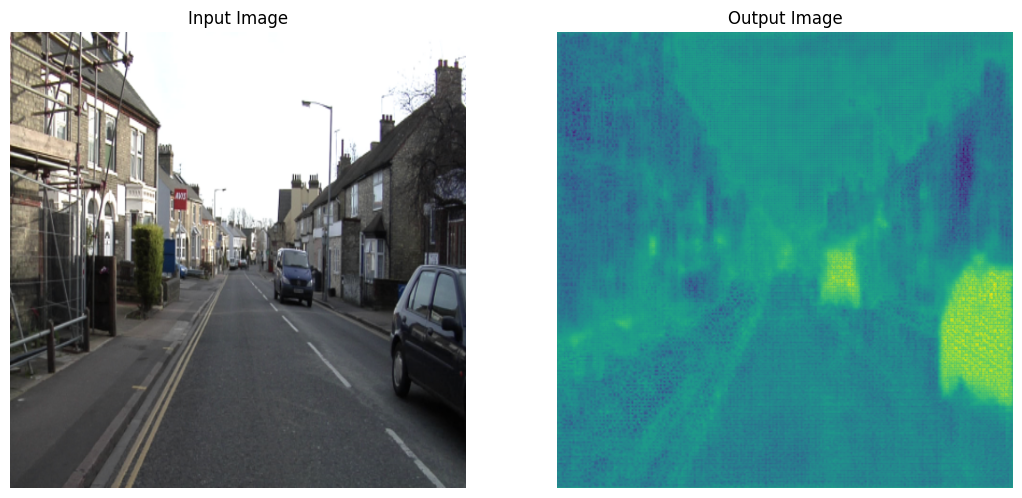

In [ ]:
# Set the class index to display
mno = 8

# Create a figure with a specified size
figure = plt.figure(figsize=(20, 10))

# Display the input image in the first subplot
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)

# Display the output segmentation for the specified class in the second subplot
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])

# Show the figure
plt.show()


In [ ]:
# Get the class with the highest score for each pixel in the output
b_ = out1.data.max(0)[1].cpu().numpy()

In [ ]:
def decode_segmap(image):
    # Define RGB values for each class label
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road_marking = [255, 69, 0]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]

    # Create an array of label colors
    label_colours = np.array([Sky, Building, Pole, Road_marking, Road,
                              Pavement, Tree, SignSymbol, Fence, Car,
                              Pedestrian, Bicyclist]).astype(np.uint8)

    # Initialize empty arrays for each color channel
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    # Map each label to its corresponding RGB color
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    # Combine the color channels into a single RGB image
    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r

    return rgb


In [ ]:
# Decode the ground truth segmentation image into RGB format
true_seg = decode_segmap(smg_)

# Decode the predicted segmentation image into RGB format
pred_seg = decode_segmap(b_)


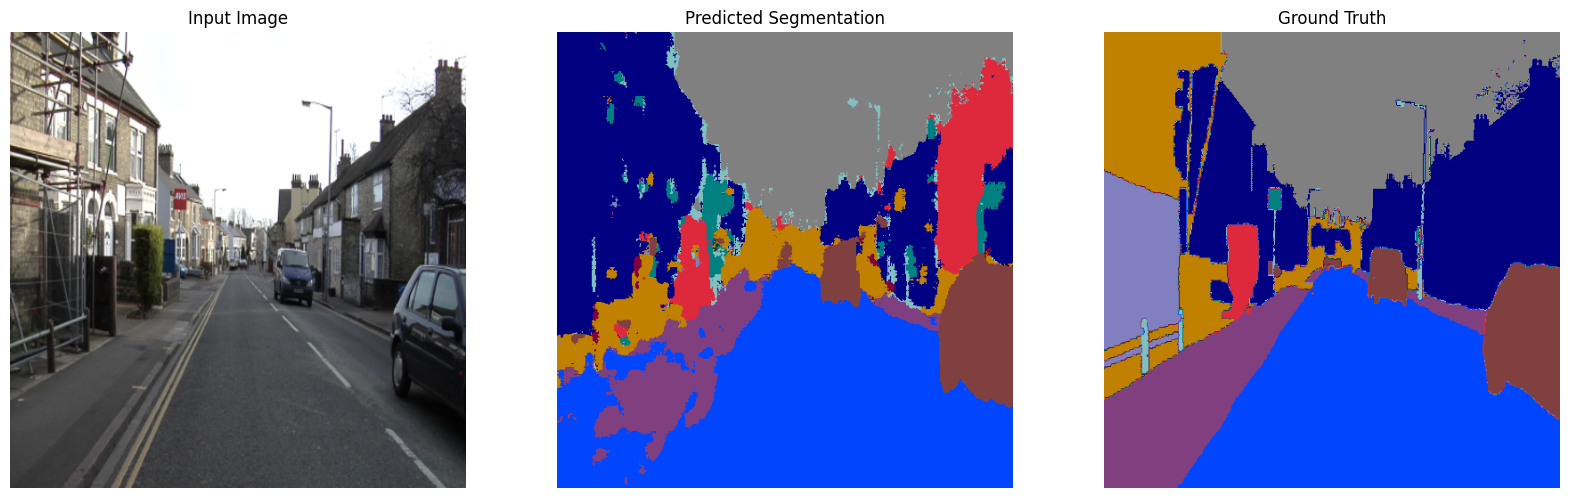

In [ ]:
# Create a figure with a specified size
figure = plt.figure(figsize=(20, 10))

# Display the input image in the first subplot
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)

# Display the predicted segmentation in the second subplot
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)

# Display the ground truth segmentation in the third subplot
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)

# Show the figure
plt.show()


In [ ]:
def create_test_video(image_folder, video_name, fps=5):
    # Get list of all PNG images in the specified folder
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

    # Sort the images by name
    images.sort()

    # Read the first image to obtain the frame size
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # You can change 'DIVX' to other codecs compatible with your system
    video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))  # fps is the frame rate

    # Write each image to the video
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    # Release the VideoWriter object
    video.release()


In [ ]:
# Create a test video from images in the specified folder
create_test_video('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/test/', 'test_video.avi')


In [ ]:
def process_image(file_path):
    # Read the input image using matplotlib
    img = plt.imread(file_path)

    # Resize the image to 512x512 using nearest neighbor interpolation
    img = cv2.resize(img, (512, 512), cv2.INTER_NEAREST)

    # Convert the image to a torch tensor and add a batch dimension
    img = torch.tensor(img).unsqueeze(0).float()

    # Change the image format to match the expected input shape (C x H x W) and move to GPU
    img = img.transpose(2, 3).transpose(1, 2).to('cuda')

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model to get predictions
        output = enet(img)

    # Get the predicted class for each pixel
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Decode the predicted segmentation map into RGB format
    segmented_img = decode_segmap(pred)

    return segmented_img


In [ ]:
def create_video(image_folder, video_name, fps=5):
    # Get sorted list of PNG files in the image folder
    files = [os.path.join(image_folder, f) for f in sorted(os.listdir(image_folder)) if f.endswith('.png')]

    # Process the first image to obtain frame size
    frame = process_image(files[0])
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    # Iterate over all files and process each image
    for file in files:
        # Process the image to get the segmented frame
        frame = process_image(file)

        # Convert the RGB frame to BGR format for OpenCV
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Get the base filename without extension
        base_filename = os.path.basename(file)
        base_filename = os.path.splitext(base_filename)[0]

        # Save the segmented mask image
        cv2.imwrite(f'/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/segmasks/{base_filename}_mask.png', frame)

        # Write the frame to the video
        video.write(frame)

    # Release the VideoWriter object
    video.release()


In [ ]:
# Create a video from the images in the specified folder
create_video('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/test/', 'segmentation_video.avi')


In [ ]:
def create_gt(image_folder):
    # Get sorted list of PNG files in the image folder
    files = [os.path.join(image_folder, f) for f in sorted(os.listdir(image_folder)) if f.endswith('.png')]

    # Iterate over all files and process each image
    for file in files:
        # Open the ground truth image using PIL
        frame = Image.open(file)

        # Resize the image to 512x512 using nearest neighbor interpolation
        frame = cv2.resize(np.array(frame), (512, 512), cv2.INTER_NEAREST)

        # Decode the ground truth segmentation map into RGB format
        frame = decode_segmap(frame)

        # Convert the RGB frame to BGR format for OpenCV
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Get the base filename without extension
        base_filename = os.path.basename(file)
        base_filename = os.path.splitext(base_filename)[0]

        # Save the ground truth mask image
        cv2.imwrite(f'/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/gtmasks/{base_filename}_gt.png', frame)


In [ ]:
# Generate ground truth masks from the images in the specified folder
create_gt('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/testannot/')


In [ ]:
# Get a sorted list of all predicted mask files in the 'segmasks' directory
pred_mask = sorted(glob(os.path.join('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/segmasks/', '*')))

# Get a sorted list of all ground truth mask files in the 'testannot' directory
gt_mask = sorted(glob(os.path.join('/home/rishie/Documents/Semester-2/ENPM673/Final Project/CamVid/testannot/', '*')))


In [ ]:
# Lists to store accuracy, F1 scores, and Jaccard scores for each image
accuracies = []
f1_scores = []
jaccard_scores = []

# Dictionary to track class-specific accuracies
class_accuracies = {}

# Iterate over predicted and ground truth mask files
for pred_y, gt_y in tqdm(zip(pred_mask, gt_mask), total=len(pred_mask)):
    # Read the predicted mask image and convert to RGB format
    pred_y = cv2.imread(pred_y)
    pred_y = cv2.cvtColor(pred_y, cv2.COLOR_BGR2RGB)
    pred_y = pred_y.astype(np.int32).flatten()

    # Read the ground truth mask image, resize, decode, and convert to flat array
    gt_y = Image.open(gt_y)
    gt_y = cv2.resize(np.array(gt_y), (512, 512), cv2.INTER_NEAREST)
    gt_y = decode_segmap(gt_y)
    gt_y = gt_y.astype(np.int32).flatten()

    # Calculate accuracy
    acc_val = accuracy_score(pred_y, gt_y)
    accuracies.append(acc_val)

    # Calculate F1 score for multi-class segmentation
    f1 = f1_score(gt_y, pred_y, average='macro')  # 'macro' averaging calculates metrics for each label and finds their unweighted mean
    f1_scores.append(f1)

    # Calculate Jaccard score for multi-class segmentation
    jaccard = jaccard_score(gt_y, pred_y, average='macro')  # Similar averaging as F1
    jaccard_scores.append(jaccard)


100%|█████████████████████████████████████████| 233/233 [01:17<00:00,  3.00it/s]


In [ ]:
# Calculate and print the mean accuracy across all images
print("Mean Accuracy:", np.mean(accuracies))

# Calculate and print the mean F1 score across all images
print("Mean F1 Score:", np.mean(f1_scores))

# Calculate and print the mean Jaccard score across all images
print("Mean Jaccard Score:", np.mean(jaccard_scores))


0.7544630102504136
0.6391920958046756
0.5157545133054127
